# Exemplo de K-means

Neste exemplo, vamos aplicar o algoritmo de K-means ao mesmo dataset de diabetes para identificar agrupamentos (clusters) de pacientes com base em duas variáveis. Ao final, será exibido um gráfico mostrando os clusters encontrados.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [3]:
# Carregar o dataset
url = 'https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv'
df = pd.read_csv(url)

print(f"Dataset carregado: {df.shape[0]} linhas, {df.shape[1]} colunas.")
df.head()

Dataset carregado: 768 linhas, 9 colunas.


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
# Selecionar duas features para visualização
X = df[['Glucose', 'BMI']].values

# Padronizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

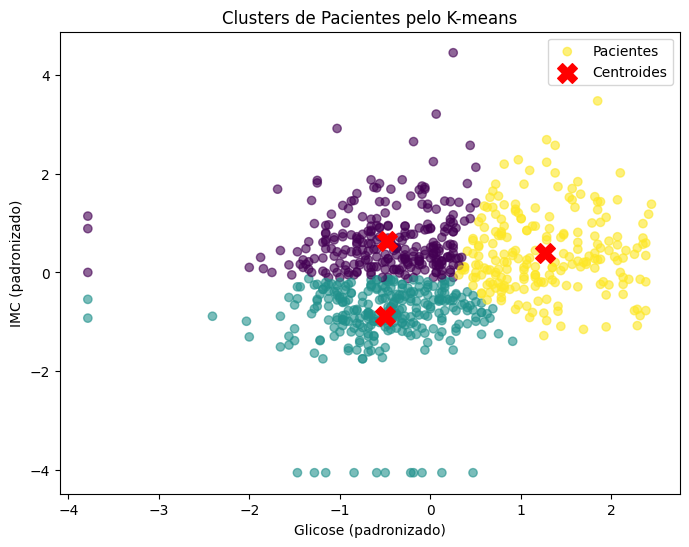

In [5]:
# Aplicar K-means
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Plotar os clusters
plt.figure(figsize=(8,6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis', alpha=0.6, label='Pacientes')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centroides')
plt.xlabel('Glicose (padronizado)')
plt.ylabel('IMC (padronizado)')
plt.title('Clusters de Pacientes pelo K-means')
plt.legend()
plt.show()

## Relação entre os clusters e o diagnóstico de diabetes

Agora, vamos analisar como os clusters encontrados pelo K-means se relacionam com o desfecho (outcome) de diabetes. Isso pode nos ajudar a entender se os agrupamentos refletem padrões de risco para a doença.

Diabetes (Outcome)    0    1
Cluster                     
0                   184   83
1                   248   38
2                    68  147


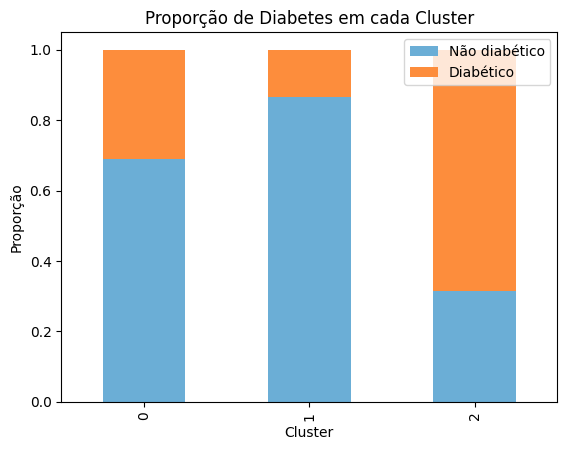

In [6]:
# Adicionar os clusters ao DataFrame
import numpy as np
df['Cluster'] = clusters

# Tabela cruzada entre cluster e outcome
tab = pd.crosstab(df['Cluster'], df['Outcome'], rownames=['Cluster'], colnames=['Diabetes (Outcome)'])
print(tab)

# Visualizar a proporção de diabéticos em cada cluster
tab_norm = tab.div(tab.sum(axis=1), axis=0)
tab_norm.plot(kind='bar', stacked=True, color=['#6baed6', '#fd8d3c'])
plt.title('Proporção de Diabetes em cada Cluster')
plt.ylabel('Proporção')
plt.xlabel('Cluster')
plt.legend(['Não diabético', 'Diabético'])
plt.show()

### Interpretação e sugestões

- A tabela e o gráfico acima mostram como cada cluster se relaciona com o diagnóstico de diabetes.
- Se um cluster apresenta maior proporção de pacientes diabéticos, isso indica que o K-means conseguiu identificar um grupo de maior risco, mesmo sem usar explicitamente o desfecho na clusterização.
- Analise as médias de glicose e IMC em cada cluster para entender o perfil de risco:

```python
for c in sorted(df['Cluster'].unique()):
    media = df[df['Cluster'] == c][['Glucose', 'BMI', 'Outcome']].mean()
    print(f"Cluster {c}: Glicose média = {media['Glucose']:.1f}, IMC médio = {media['BMI']:.1f}, Proporção diabéticos = {media['Outcome']:.2f}")
```

- Sugestão: Use os clusters para direcionar ações preventivas, focando nos grupos com maior risco identificado.
- Lembre-se: O K-means não usa o outcome para formar os grupos, então diferenças marcantes sugerem que as variáveis escolhidas (glicose e IMC) são relevantes para o risco de diabetes.

## Análise detalhada dos clusters

Vamos aprofundar a análise dos clusters, avaliando médias e desvios padrão de todas as variáveis, além de explorar a distribuição de outras variáveis relevantes.

In [7]:
# Médias e desvios padrão de todas as variáveis por cluster
descricoes = df.groupby('Cluster').agg(['mean', 'std'])
descricoes.T # Transposto para facilitar leitura

Cluster                                 0           1           2
Pregnancies              mean    3.737828    3.381119    4.595349
                         std     3.433388    3.021245    3.608010
Glucose                  mean  105.494382  104.993007  161.172093
                         std    20.452470   20.177631   18.384603
BloodPressure            mean   71.367041   63.853147   73.283721
                         std    16.919983   20.471618   19.183532
SkinThickness            mean   25.408240   14.416084   22.627907
                         std    16.474234   11.596655   17.650585
Insulin                  mean   70.913858   49.545455  131.079070
                         std    82.299129   76.157982  165.813988
BMI                      mean   37.004120   24.980769   35.096279
                         std     4.960523    5.876371    6.284344
DiabetesPedigreeFunction mean    0.463581    0.440930    0.523344
                         std     0.300646    0.313855    0.381961
Age                      mean   32.374532   30.807692   37.553488
                         std     9.822206   12.045298   12.450488
Outcome                  mean    0.310861    0.132867    0.683721
                         std     0.463715    0.340026    0.466108

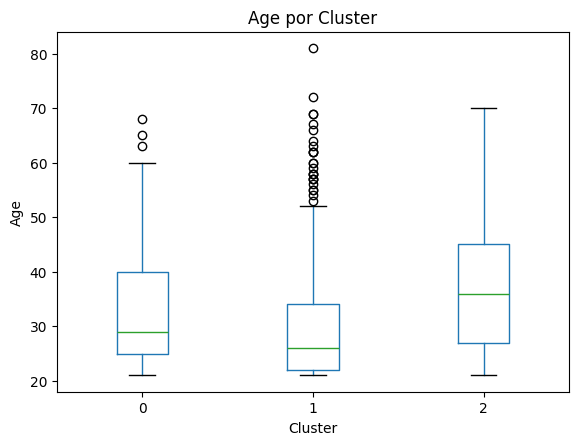

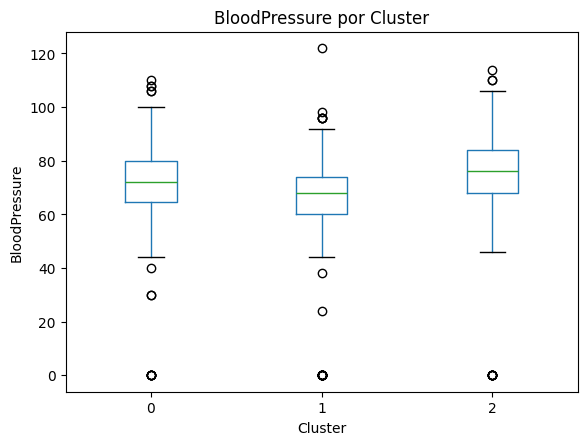

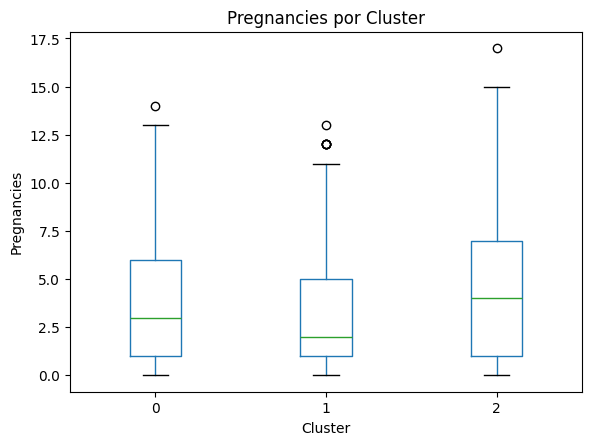

In [8]:
# Boxplots de variáveis relevantes por cluster
variaveis = ['Age', 'BloodPressure', 'Pregnancies']
for var in variaveis:
    df.boxplot(column=var, by='Cluster', grid=False)
    plt.title(f'{var} por Cluster')
    plt.suptitle('')
    plt.xlabel('Cluster')
    plt.ylabel(var)
    plt.show()

In [9]:
from sklearn.metrics import silhouette_score
score = silhouette_score(X_scaled, clusters)
print(f'Silhouette Score dos clusters: {score:.2f}')

Silhouette Score dos clusters: 0.35


In [10]:
# Usando o cluster como feature em um modelo de classificação
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Adiciona a coluna de cluster como feature
X_model = df[['Glucose', 'BMI', 'Cluster']]
y_model = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.3, random_state=42)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'Acurácia do modelo com cluster como feature: {acc:.2f}')

Acurácia do modelo com cluster como feature: 0.74


### Sugestões de análise

- Compare as médias e desvios padrão para identificar quais variáveis mais diferenciam os clusters.
- Observe os boxplots para ver se há variáveis que se distribuem de forma muito distinta entre os grupos.
- O silhouette score indica o quão bem definidos estão os clusters (quanto mais próximo de 1, melhor).
- Se a acurácia do modelo aumentar ao incluir o cluster como feature, isso sugere que os agrupamentos trazem informação relevante para a predição de diabetes.
- Você pode repetir a clusterização com outros pares de variáveis para buscar novos padrões.
- Se quiser, pode analisar a distribuição de variáveis categóricas (faixas etárias, por exemplo) ou associar os clusters a outras condições de saúde, caso o dataset possua essas informações.